In [1]:
cd ..

/home/janek/mag/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_tr_p2, data_vl_p2, idx_te, X_te, y_te = prepare_data(data_tr, data_vl, data_te, seed, 4)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_tr_p2[2]))
print(np.mean(data_vl_p2[2]))
print(np.mean(y_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_tr_p2[2]))
print(len(data_vl_p2[2]))
print(len(y_te))

54490
25510

27136
6426
6438


In [7]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

In [8]:
#FIRST PHASE
T.manual_seed(seed)
reasoner_original = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_original = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_original)} parameters')
print(f'created {len(encoders_original)} encoders with {paramcount(encoders_original[0])} parameters each')

T.manual_seed(seed)
reasoner_mod = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders_mod = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]
print(f'created reasoner with {paramcount(reasoner_mod)} parameters')
print(f'created {len(encoders_mod)} encoders with {paramcount(encoders_mod[0])} parameters each')

train_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    random.seed(seed)
    if reasoner_name == 'original reasoner':
        train(data_tr, data_vl, reasoner, encoders_original, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger)
    else:
        train_mod(data_tr, data_vl, reasoner, encoders_mod, epoch_count=epoch_count, batch_size=batch_size, run_name=reasoner_name, logger=train_logger, identities_weight=0.028, identitity_weight_decay=0.96)


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each
original reasoner
train epoch 00/15 | batch 1704/1703 | loss 0.7203 | val loss 0.7206 | acc 0.2125 | f1 0.3505 | prec 0.2125 | recall 0.9994 | roc auc 0.5276 | pr auc 0.2303 | elapsed 17.45s
train epoch 01/15 | batch 1704/1703 | loss 0.5899 | val loss 0.5075 | acc 0.7978 | f1 0.1014 | prec 0.9151 | recall 0.0537 | roc auc 0.5890 | pr auc 0.3256 | elapsed 33.52s
train epoch 02/15 | batch 1704/1703 | loss 0.4514 | val loss 0.4774 | acc 0.8013 | f1 0.2551 | prec 0.6276 | recall 0.1601 | roc auc 0.7018 | pr auc 0.4395 | elapsed 34.89s
train epoch 03/15 | batch 1704/1703 | loss 0.3383 | val loss 0.4917 | acc 0.8128 | f1 0.3947 | prec 0.6314 | recall 0.2871 | roc auc 0.7389 | pr auc 0.5165 | elapsed 32.72s
train epoch 04/15 | batch 1704/1703 | loss 0.2566 | val loss 0.5049 | acc 0.8194 | f1 0.4667 | prec 0.6269 | recall 0.3717

In [9]:
## --- SECOND PHASE
trained_test_encoders = {}
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('original reasoner', reasoner_original), ('modified reasoner', reasoner_mod)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'original reasoner':
        train(data_tr_p2, data_vl_p2, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)
    else:
        train_mod(data_tr_p2, data_vl_p2, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)


original reasoner


train epoch 00/10 | batch 849/848 | loss 1.2253 | val loss 1.2663 | acc 0.6334 | f1 0.3632 | prec 0.2841 | recall 0.5034 | roc auc 0.6302 | pr auc 0.3802 | elapsed 6.06s
train epoch 01/10 | batch 849/848 | loss 1.0615 | val loss 1.1173 | acc 0.6664 | f1 0.3807 | prec 0.3098 | recall 0.4936 | roc auc 0.6525 | pr auc 0.4033 | elapsed 11.03s
train epoch 02/10 | batch 849/848 | loss 0.7526 | val loss 1.0048 | acc 0.6920 | f1 0.3976 | prec 0.3349 | recall 0.4891 | roc auc 0.6733 | pr auc 0.4270 | elapsed 11.27s
train epoch 03/10 | batch 849/848 | loss 0.5328 | val loss 0.9266 | acc 0.7182 | f1 0.4249 | prec 0.3688 | recall 0.5011 | roc auc 0.6913 | pr auc 0.4489 | elapsed 11.88s
train epoch 04/10 | batch 849/848 | loss 0.3878 | val loss 0.8741 | acc 0.7340 | f1 0.4384 | prec 0.3905 | recall 0.4996 | roc auc 0.7060 | pr auc 0.4689 | elapsed 10.86s
train epoch 05/10 | batch 849/848 | loss 0.2958 | val loss 0.8390 | acc 0.7474 | f1 0.4530 | prec 0.4118 | recall 0.5034 | roc auc 0.7175 | pr auc

In [10]:
with T.no_grad():
    _, _, Y_te_orig = eval_batch(reasoner_original, trained_test_encoders['original reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_mod = eval_batch(reasoner_mod, trained_test_encoders['modified reasoner'], X_te, y_te, idx_te)

local/out/exp/20240808T161858


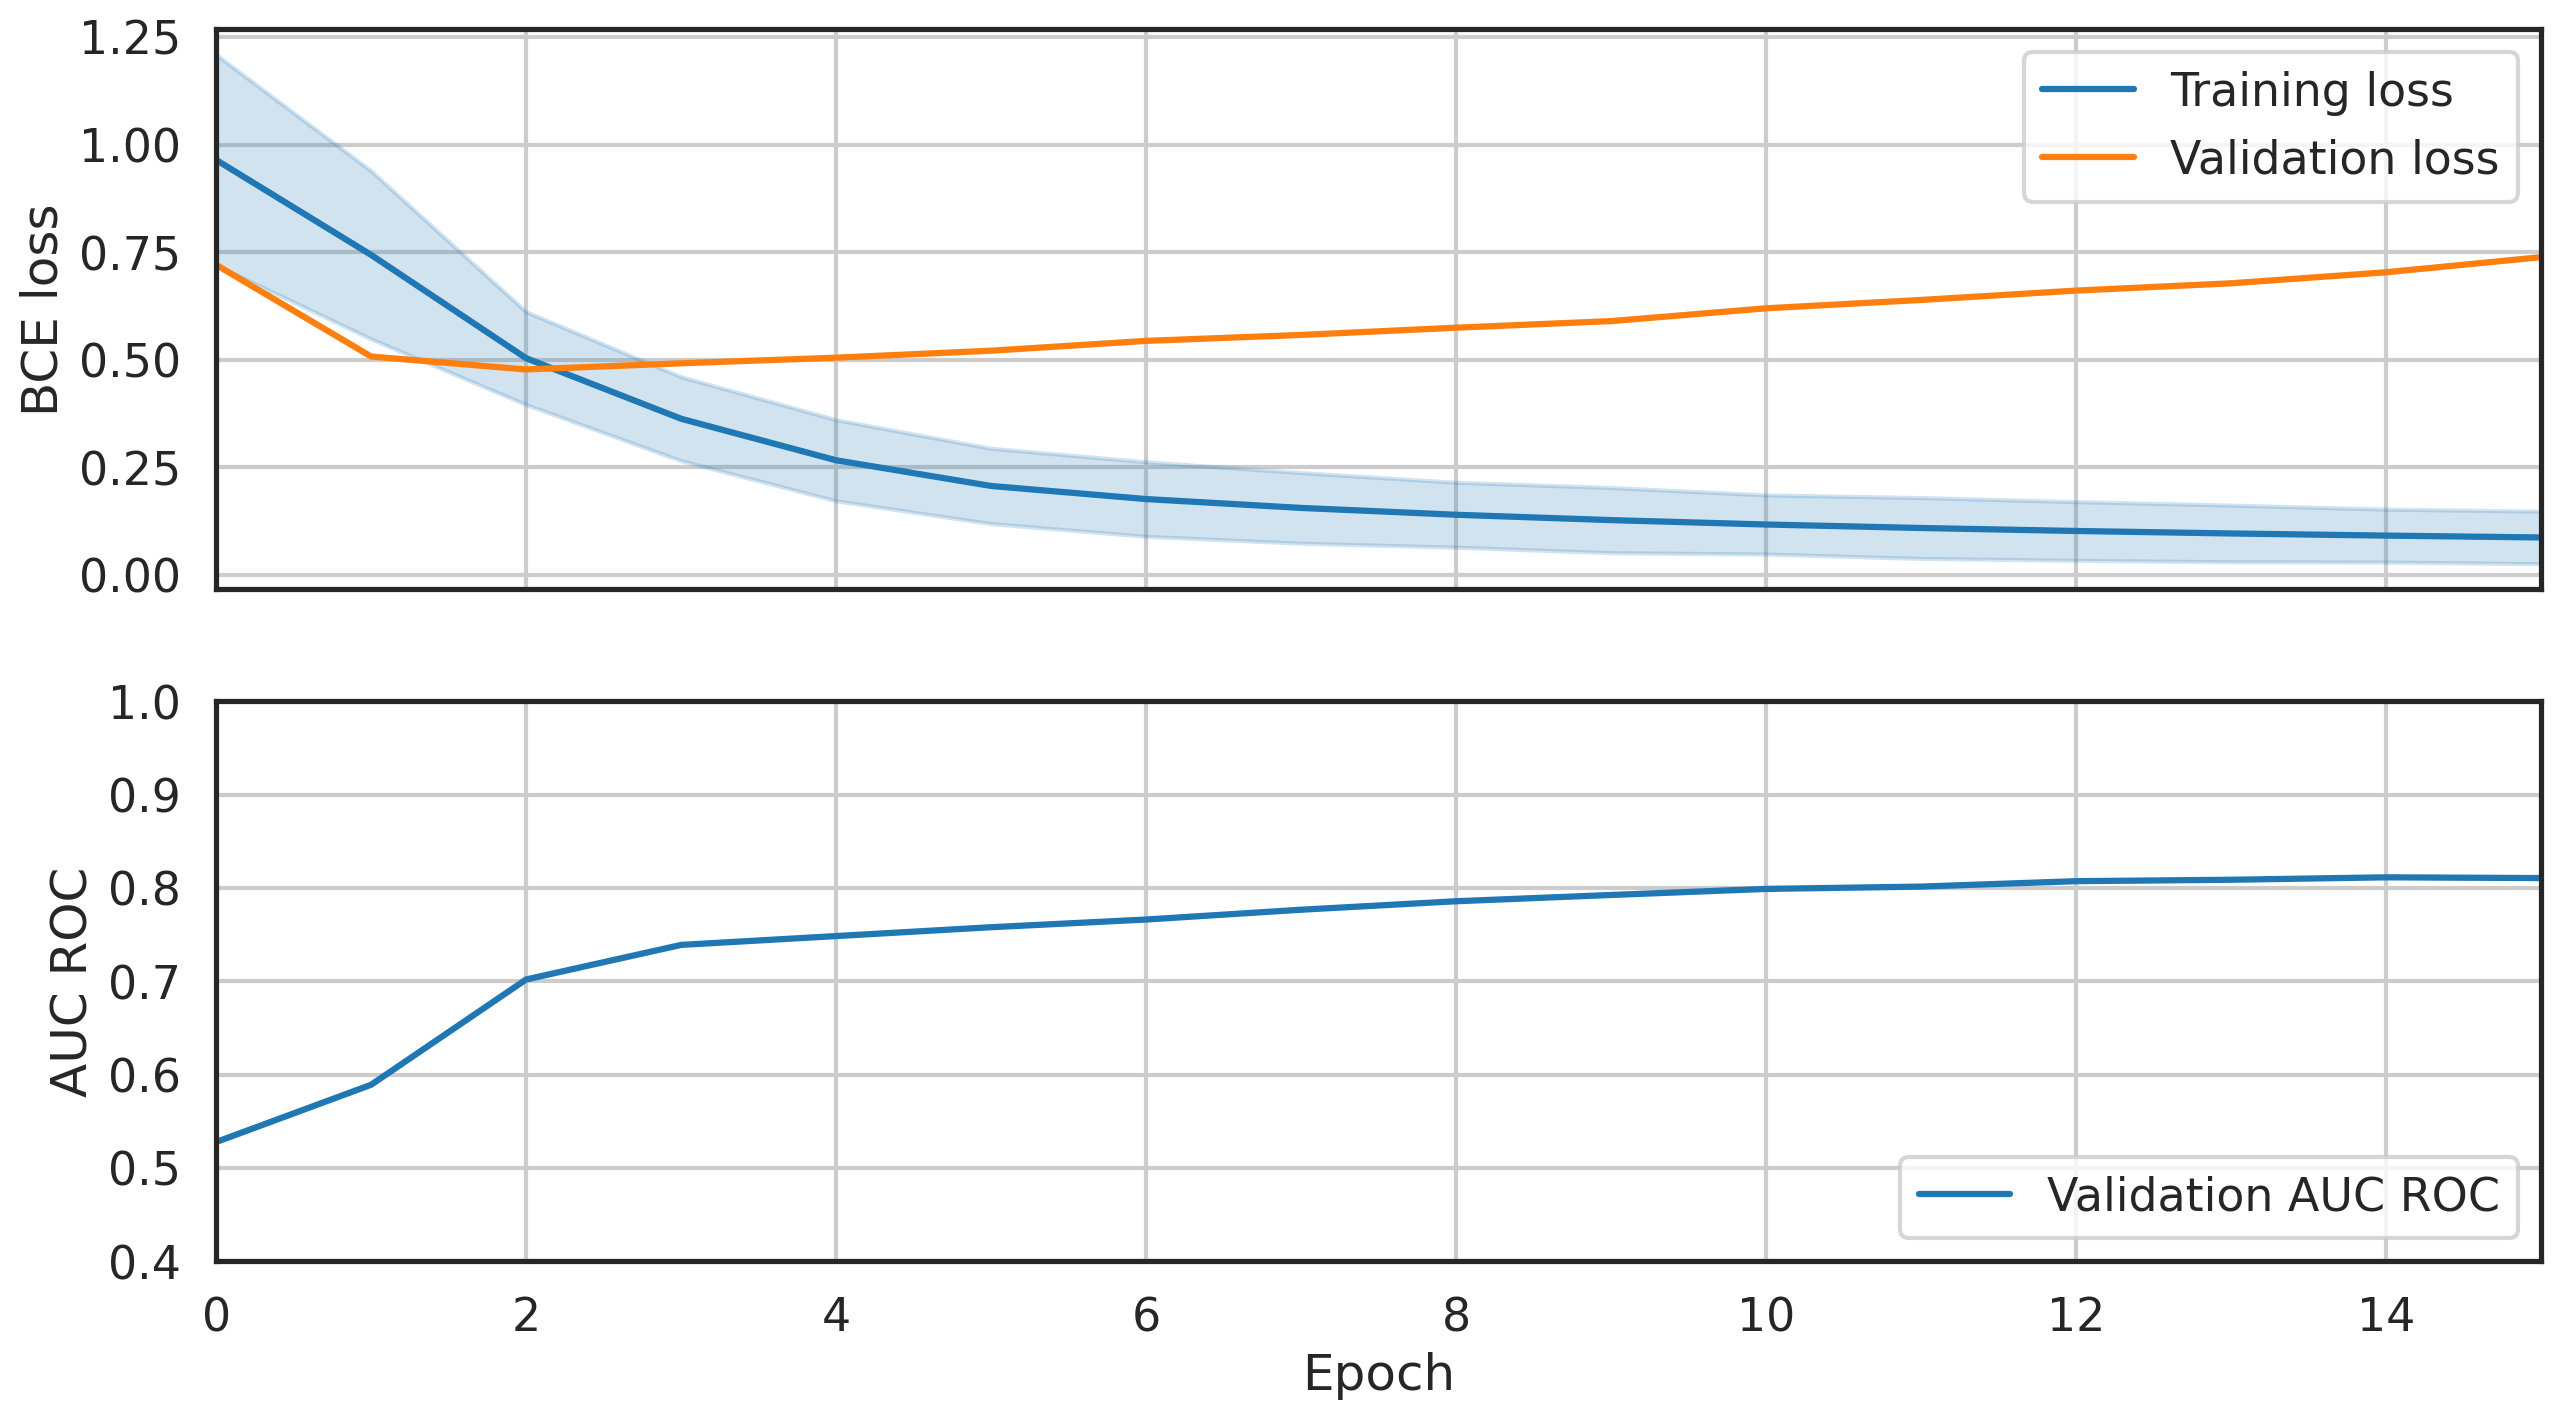

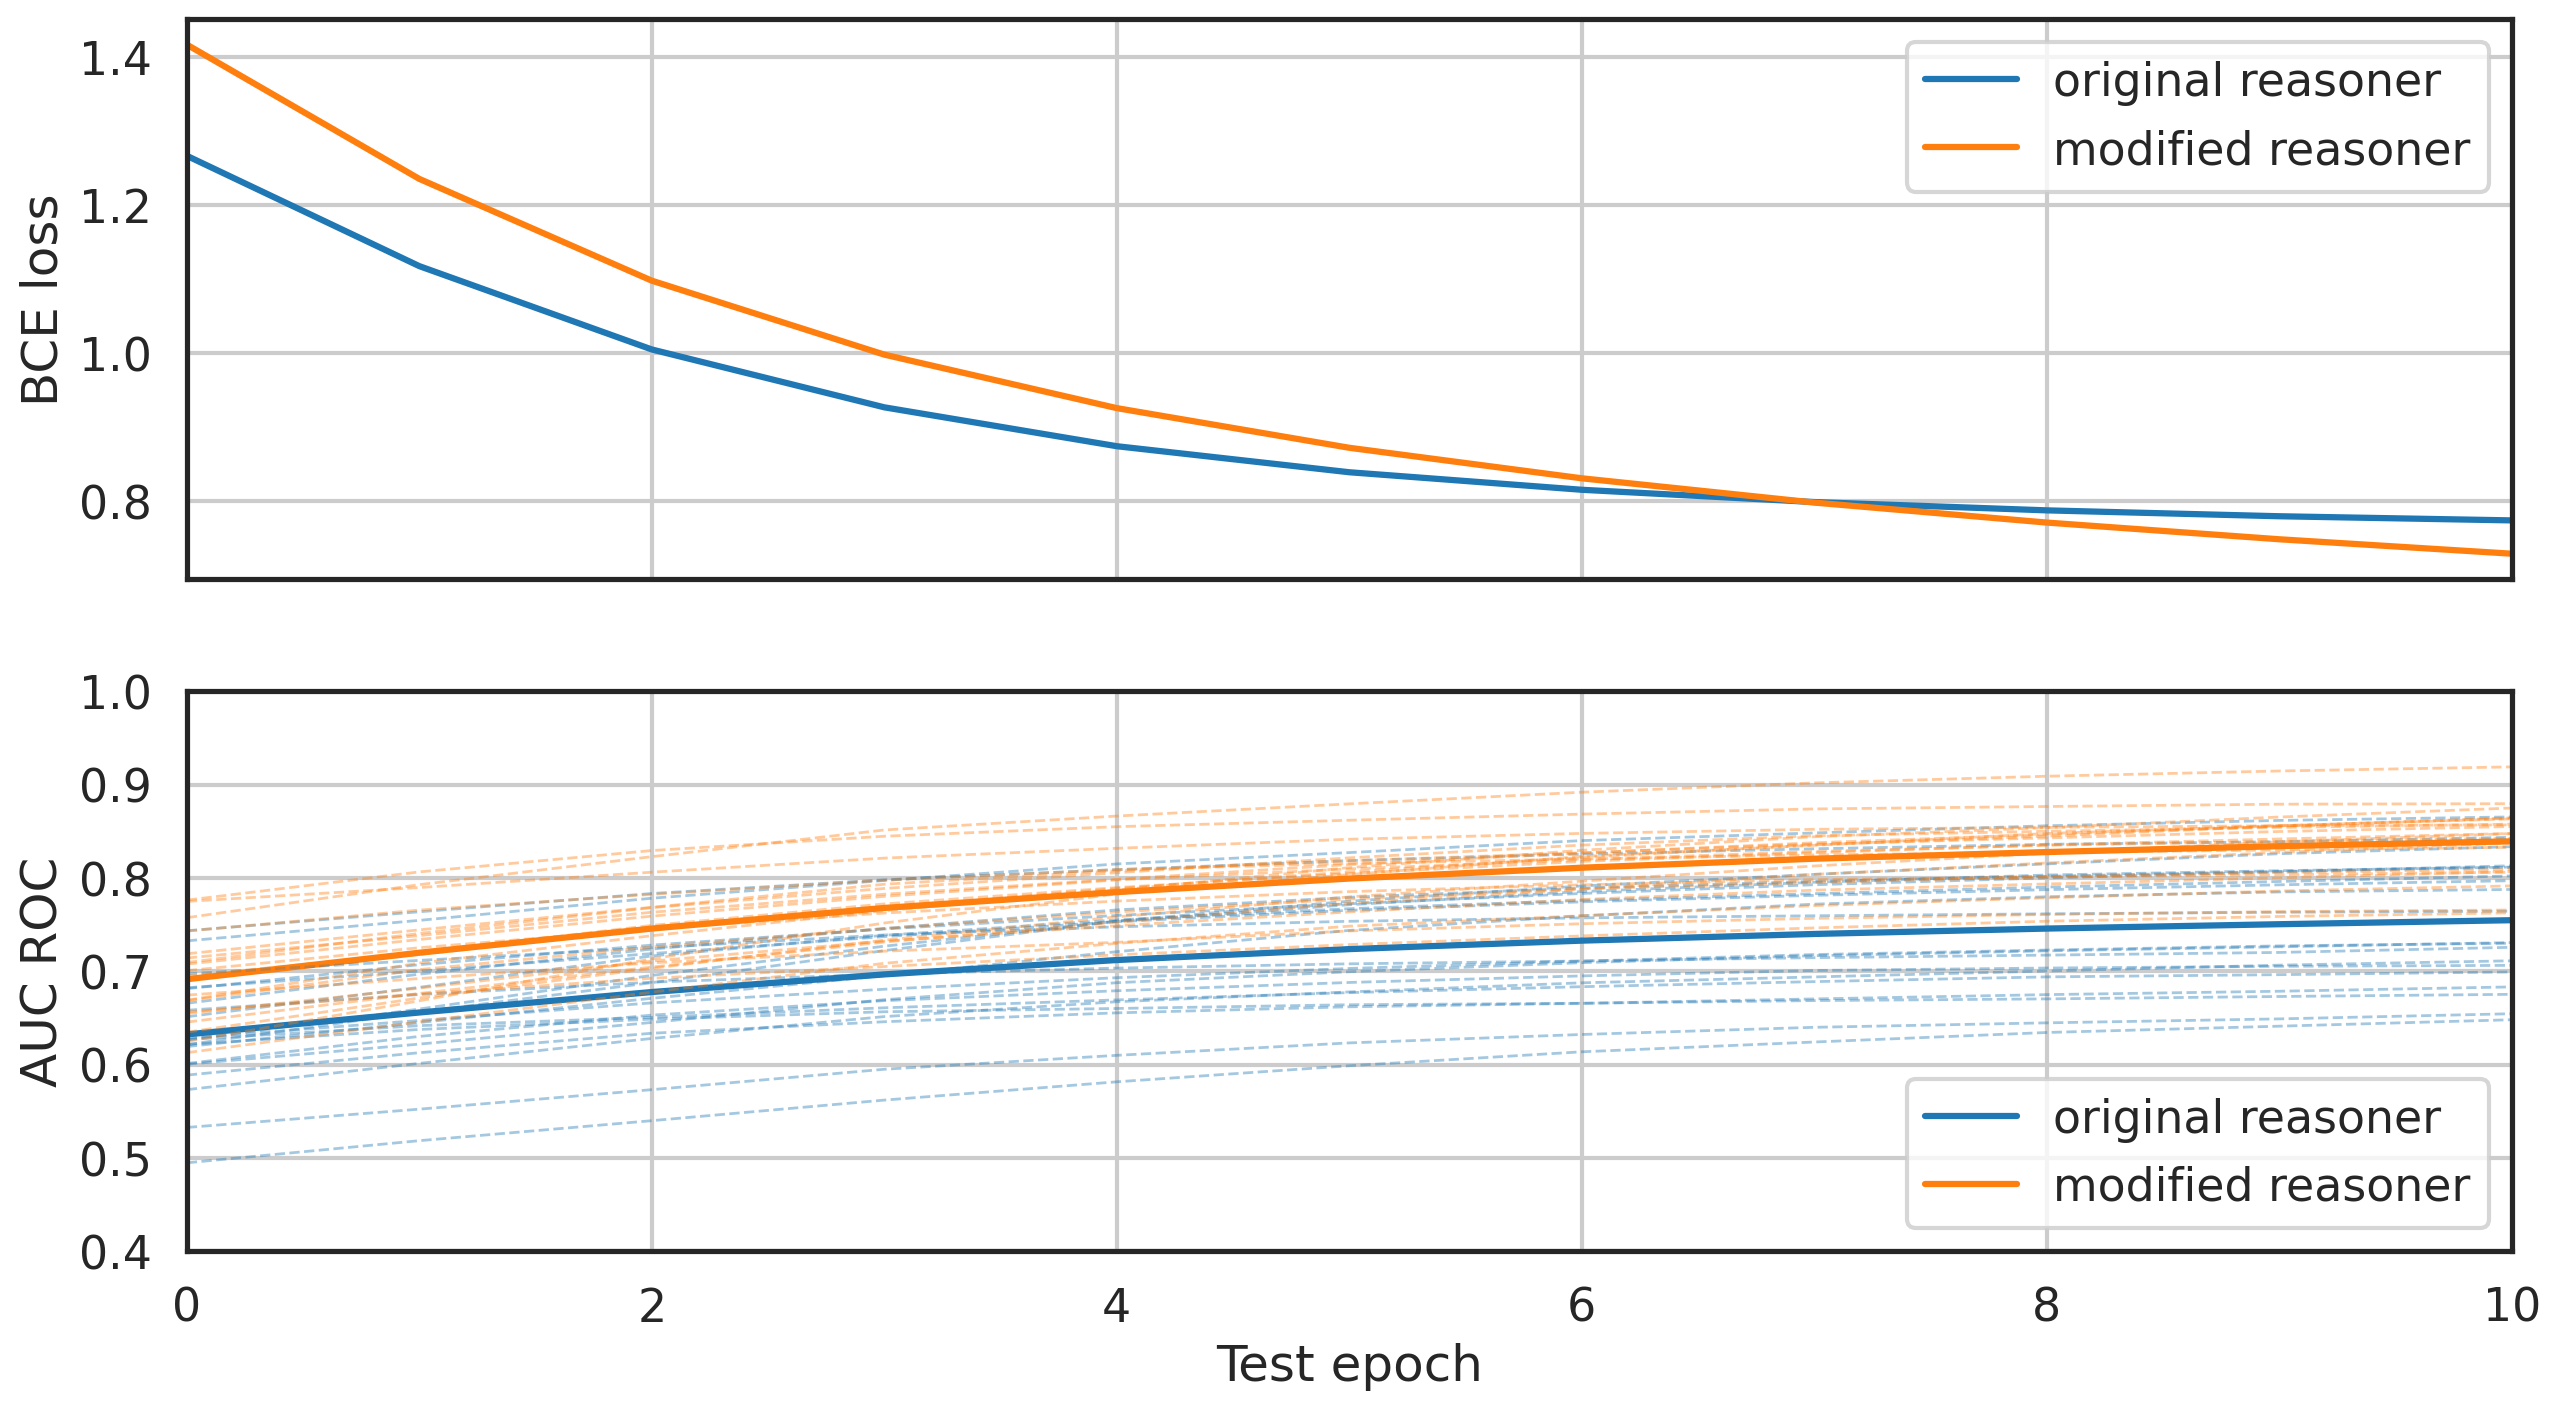

original
             mean       std     micro
acc      0.800075  0.052253  0.799627
prec     0.544056  0.132389  0.518868
recall   0.579634  0.100692  0.572065
f1       0.545887  0.063398  0.544170
auc_roc  0.786091  0.057073  0.777470
auc_pr   0.611736  0.084903  0.585394
modified
             mean       std     micro
acc      0.760997  0.061088  0.761417
prec     0.469432  0.112298  0.458260
recall   0.779462  0.071074  0.774889
f1       0.577055  0.084408  0.575925
auc_roc  0.856273  0.044765  0.855205
auc_pr   0.723828  0.094834  0.724254


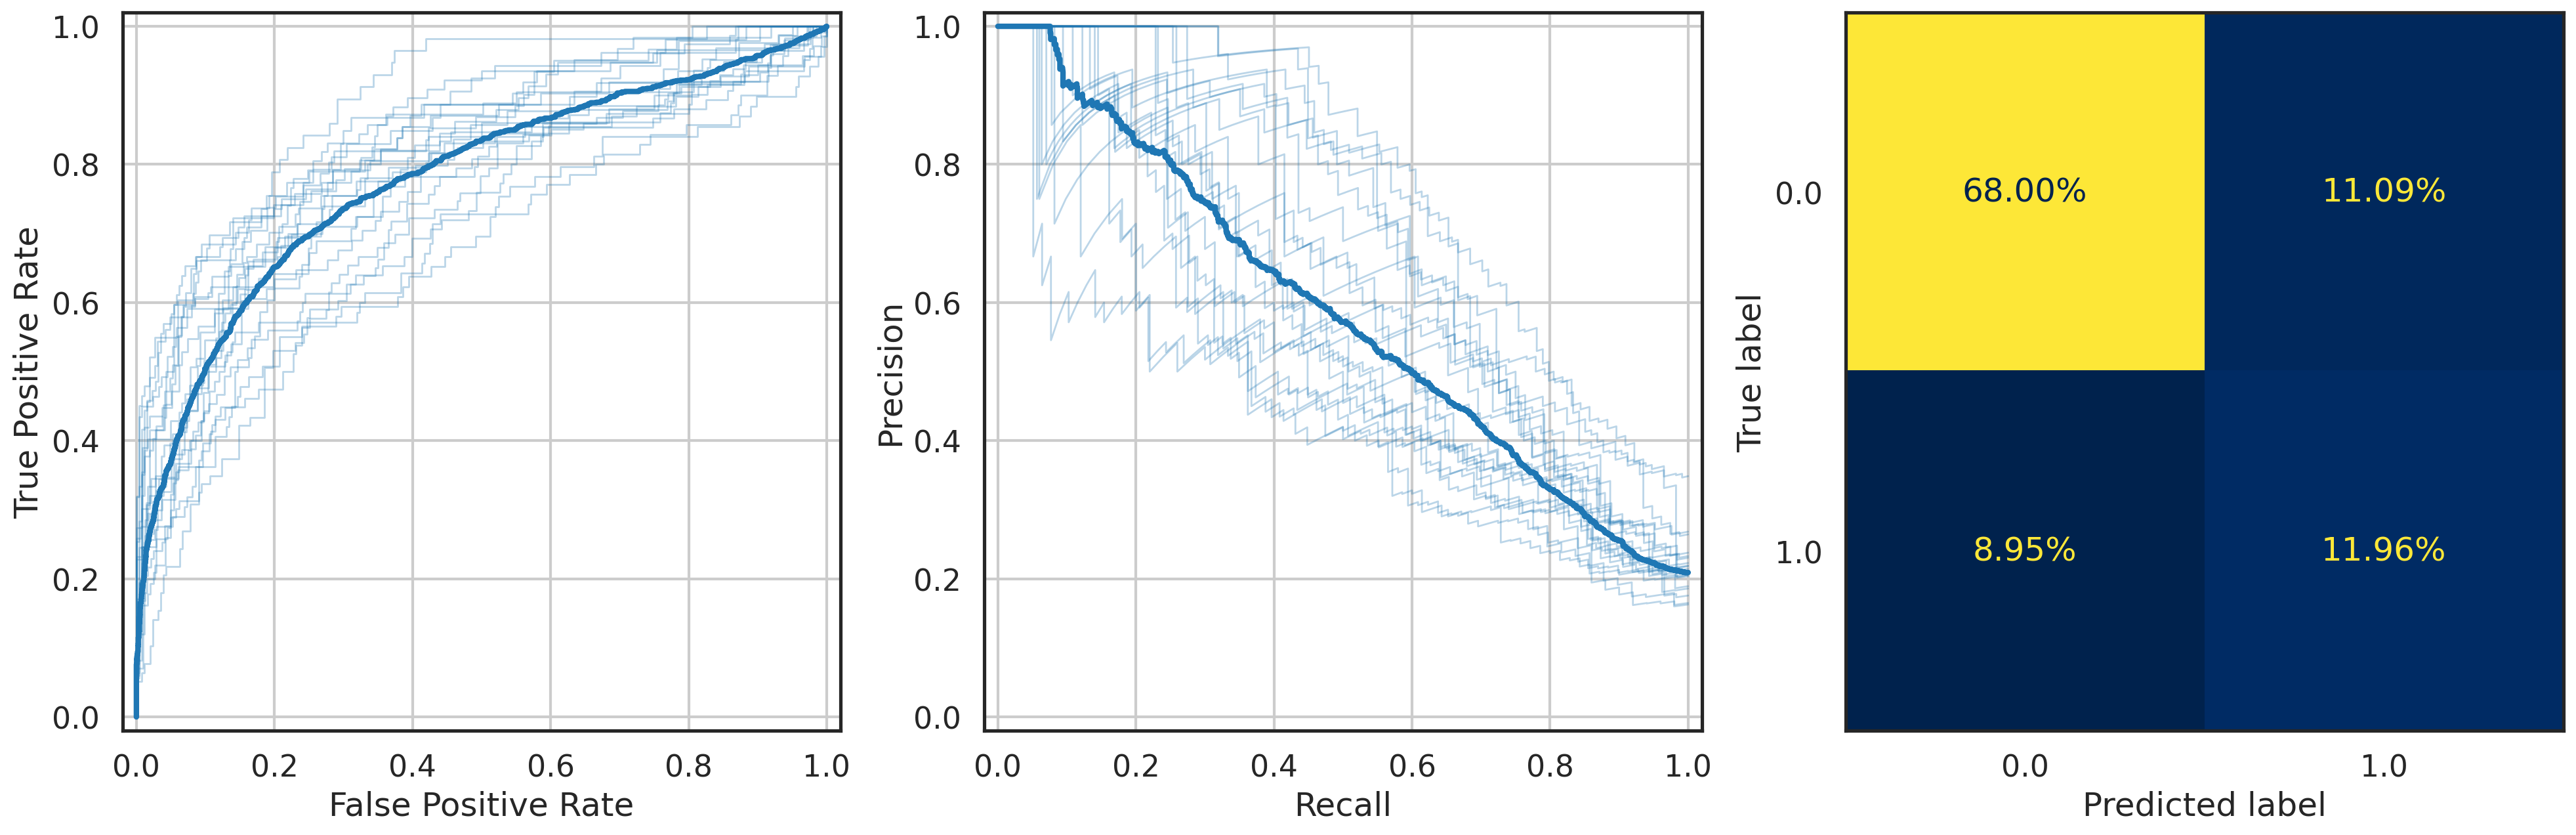

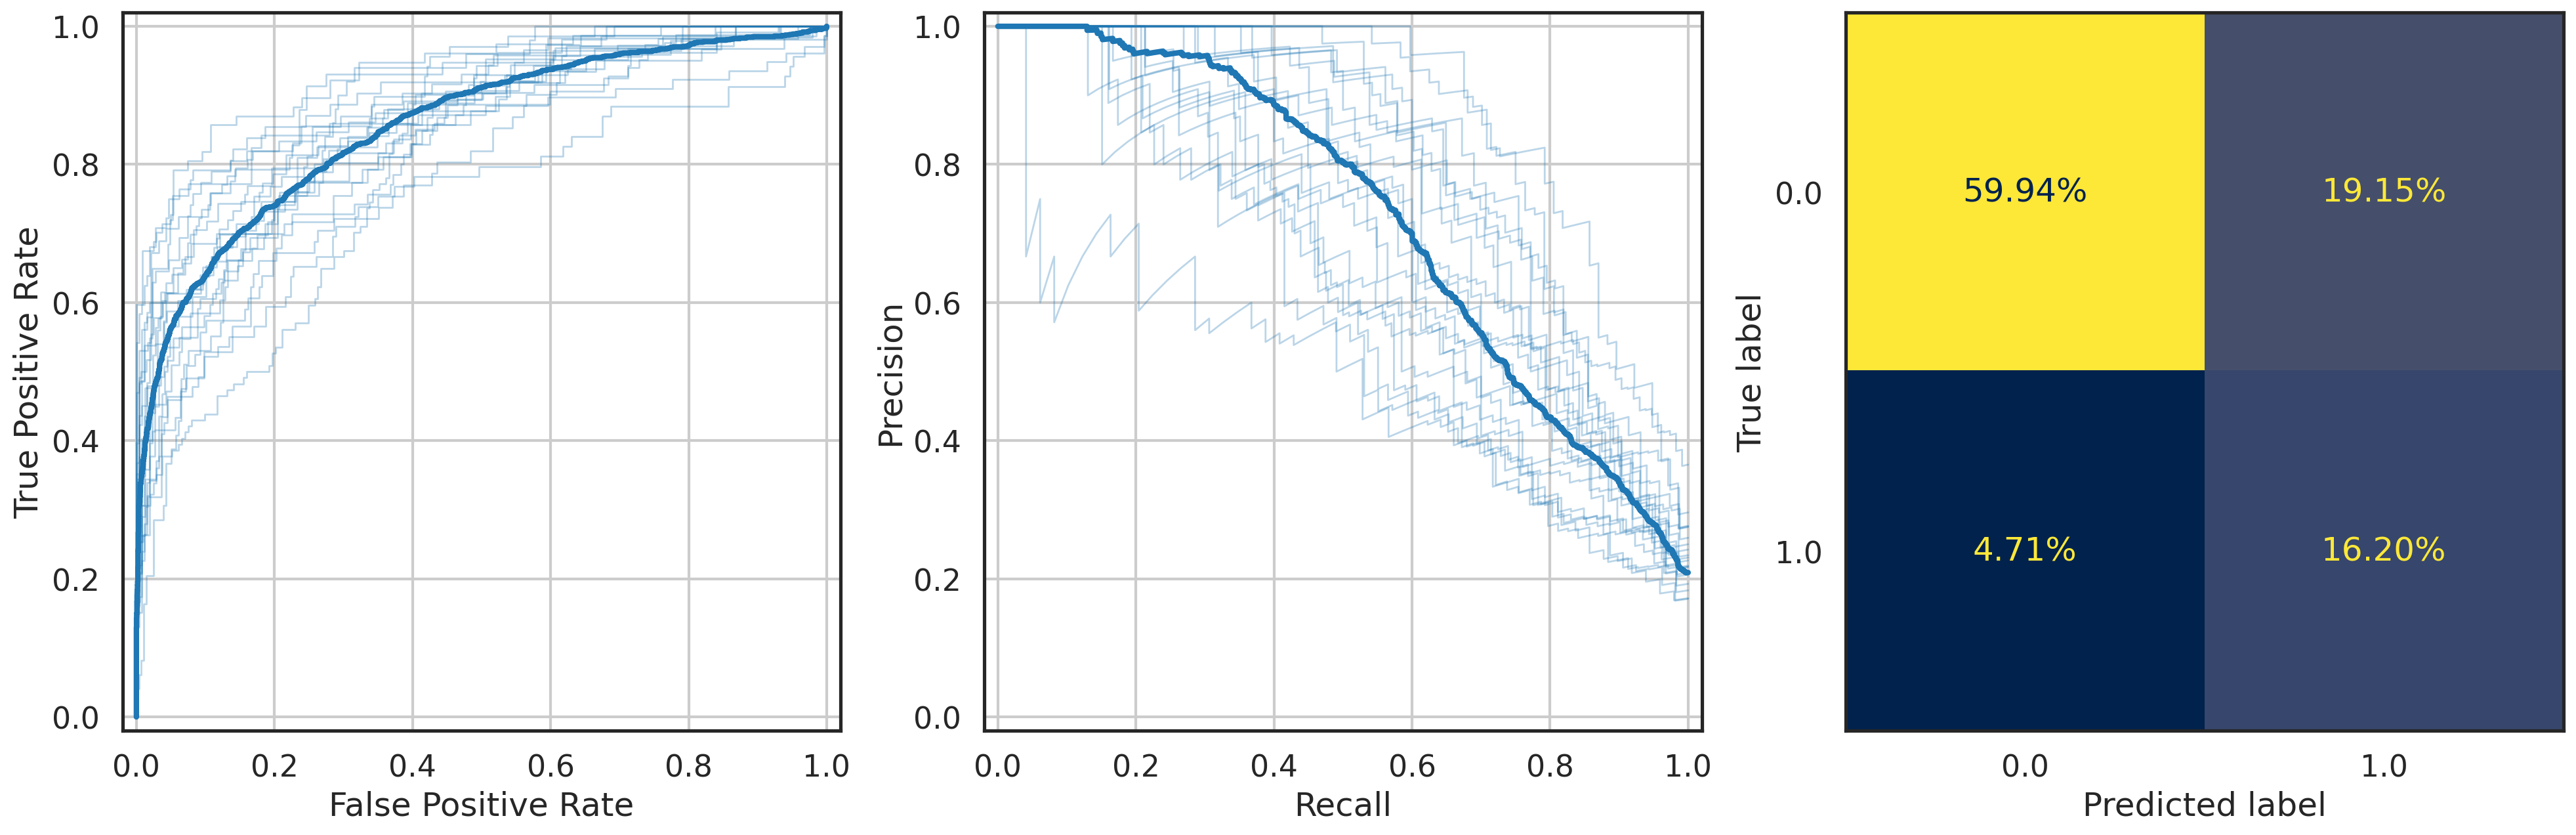

In [11]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(reasoner_original.state_dict(), base+'/reasonerO.pt')
T.save(reasoner_mod.state_dict(), base+'/reasonerM.pt')

df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_orig=Y_te_orig, Y_te_mod=Y_te_mod))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print('original')
print(report(test_onto, y_te, np.array(Y_te_orig), idx_te, save=base+'/%-trained'))
print('modified')
print(report(test_onto, y_te, np.array(Y_te_mod), idx_te, save=base+'/%-random'))

In [12]:
from src.id import print_identity_results
print(print_identity_results(reasoner_original,trained_test_encoders['original reasoner'], seed))

Double Negation:
  Mean Loss: 0.236346
  Std Dev Loss: 0.033967
  Mean Diff: 0.559653
  Std Dev Diff: 0.104078

Duality of Top and Bottom:
  Mean Loss: 0.335481
  Std Dev Loss: 0.000000
  Mean Diff: 0.692846
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.129764
  Std Dev Loss: 0.038282
  Mean Diff: 0.314580
  Std Dev Diff: 0.094886

Associativity:
  Mean Loss: 0.050347
  Std Dev Loss: 0.033040
  Mean Diff: 0.098924
  Std Dev Diff: 0.046248

Commutativity:
  Mean Loss: 0.037959
  Std Dev Loss: 0.012948
  Mean Diff: 0.088252
  Std Dev Diff: 0.031726

Contradiction:
  Mean Loss: 0.418690
  Std Dev Loss: 0.017543
  Mean Diff: 0.876305
  Std Dev Diff: 0.051778

Identity with Top:
  Mean Loss: 0.171646
  Std Dev Loss: 0.038135
  Mean Diff: 0.467007
  Std Dev Diff: 0.124714

Absorption by Bottom:
  Mean Loss: 0.609296
  Std Dev Loss: 0.026983
  Mean Diff: 1.263265
  Std Dev Diff: 0.069831

Top Concept Subsumption:
  Mean Loss: 0.000867
  Std Dev Loss: 0.000953
  Mean Diff: N/A
  Std De

In [13]:
print(print_identity_results(reasoner_mod,trained_test_encoders['modified reasoner'], seed))

Double Negation:
  Mean Loss: 0.000009
  Std Dev Loss: 0.000003
  Mean Diff: 0.000021
  Std Dev Diff: 0.000009

Duality of Top and Bottom:
  Mean Loss: 0.000164
  Std Dev Loss: 0.000000
  Mean Diff: 0.000463
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.124697
  Std Dev Loss: 0.025529
  Mean Diff: 0.301574
  Std Dev Diff: 0.073275

Associativity:
  Mean Loss: 0.018180
  Std Dev Loss: 0.006207
  Mean Diff: 0.041753
  Std Dev Diff: 0.014218

Commutativity:
  Mean Loss: 0.021786
  Std Dev Loss: 0.008102
  Mean Diff: 0.053661
  Std Dev Diff: 0.020974

Contradiction:
  Mean Loss: 0.121920
  Std Dev Loss: 0.028951
  Mean Diff: 0.200581
  Std Dev Diff: 0.039508

Identity with Top:
  Mean Loss: 0.064484
  Std Dev Loss: 0.017344
  Mean Diff: 0.157462
  Std Dev Diff: 0.048260

Absorption by Bottom:
  Mean Loss: 0.025695
  Std Dev Loss: 0.009302
  Mean Diff: 0.053733
  Std Dev Diff: 0.015205

Top Concept Subsumption:
  Mean Loss: 0.000356
  Std Dev Loss: 0.000344
  Mean Diff: N/A
  Std De